In [1]:
from datasets.nuscenes_dataset import NuScenesDataset

In [2]:
import os 
nuscenes_dataset_path = '/home/cedric/nuscenes2kitti/output/'
sequence = '0061'
sam_labels_path = None

dataset = NuScenesDataset(nuscenes_dataset_path, 
                       sequence, 
                       sam_labels_path)

labels_folder = nuscenes_dataset_path + 'sequences/' + sequence + '/labels/'

no timestamps found


In [3]:
from segmentation.aggregated_segmentation import AggregatedSegmentation

aggregated_segmentation = AggregatedSegmentation(dataset,dataset_name='nuScenes',sequence=sequence,window=5)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
PatchWorkpp::PatchWorkpp() - INITIALIZATION COMPLETE


### Run baselines

In [4]:
import os
import numpy as np

from tqdm import tqdm

visual_labels = []
geometrical_labels = []
gt_labels = []

cnt = 0 
for i in tqdm(range(0, len(dataset.poses))):
    geometrical_labels.append(aggregated_segmentation.segment_instances(i))
    labels_file_path = os.path.join(labels_folder, '{}.label'.format(str(i).zfill(6)))
    gt_labels.append(np.fromfile(labels_file_path, dtype=np.uint32))

    cnt += 1


  0%|          | 0/39 [00:00<?, ?it/s]/home/cedric/unsup_3d_instances/pipeline/segmentation/utils/aggregate.py:111: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.expand_dims(hpoints, 2) * np.linalg.inv(pose).T, axis=1)[:,:3]
/home/cedric/anaconda3/envs/torch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
  3%|▎         | 1/39 [00:02<01:32,  2.43s/it]/home/cedric/unsup_3d_instances/pipeline/segmentation/utils/aggregate.py:111: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.expand_dims(hpoints, 2) * np.linalg.inv(pose).T, axis=1)[:,:3]
/home/cedric/anaconda3/envs/torch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
  5%|▌         | 2/39 [00:04<01:26,  2.33s/it]/home/cedric/unsup_3d_instances/pipe

### Visualize baselines

In [5]:
import random

def generate_random_colors(N):
    colors = []
    for _ in range(N):
        colors.append([random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)])

    return colors

random_colors = generate_random_colors(2000)

In [6]:
import numpy as np
import open3d as o3d

def color_points_by_labels(points, labels):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    colors = []
    unique_clusters = list(np.unique(labels))

    for i in range(labels.shape[0]):
        colors.append(random_colors[unique_clusters.index(labels[i]) + 1])

    pcd.colors = o3d.utility.Vector3dVector(np.vstack(colors) / 255)

    return pcd

In [7]:
index = 0
points = dataset.get_point_cloud(50*index)
#o3d.visualization.draw_geometries([color_points_by_labels(points, gt_labels[index])])
o3d.visualization.draw_geometries([color_points_by_labels(points, geometrical_labels[index])])

### Evaluation

In [8]:
import instanseg
from instanseg.metrics import precision, recall, fScore

instanseg.metrics.constants.IOU_THRESHOLD_FULL = 0.5
tp_condition = 'iou'

In [9]:
import pandas as pd

results_dict = []

for i in tqdm(range(len(geometrical_labels))):

        res = {
            'index': i,
            'method': 'dbscan clustering aggregated' + str(aggregated_segmentation.window),
            'precision': precision(geometrical_labels[i].reshape(-1,), gt_labels[i], tp_condition),
            'recall': recall(geometrical_labels[i].reshape(-1,), gt_labels[i], tp_condition),
            'fscore': fScore(geometrical_labels[i].reshape(-1,), gt_labels[i], tp_condition)
        }
        
        results_dict.append(res)
    


100%|██████████| 39/39 [00:41<00:00,  1.06s/it]


In [10]:
df = pd.DataFrame.from_records(results_dict, index=np.arange(len(results_dict)))

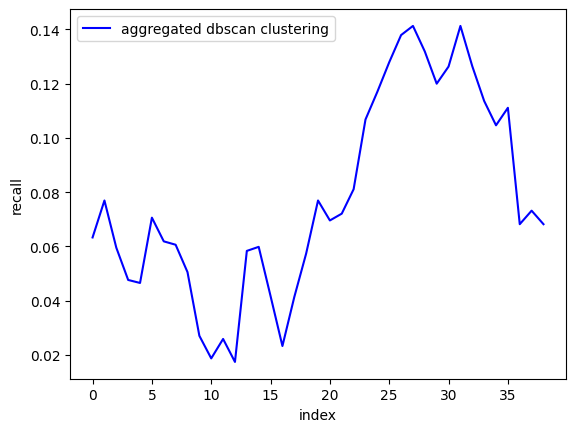

In [11]:
import matplotlib.pyplot as plt

plt.xlabel('index')  # Optional: Add X-axis label
metric = 'recall'
plt.ylabel(metric)  # Optional: Add Y-axis label
colors = ['blue','orange','red']
plt.plot(df['index'].values, df[metric].values,color='blue',label='aggregated dbscan clustering')

plt.legend()

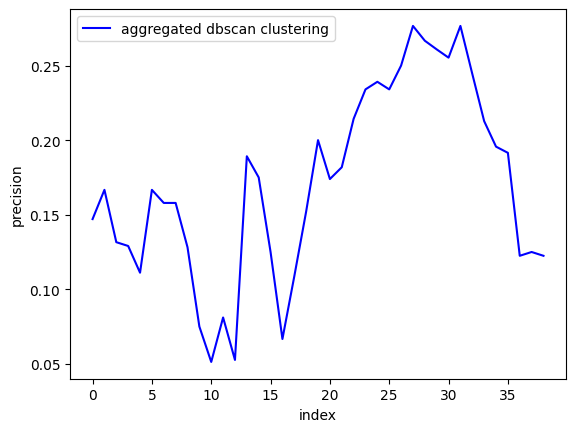

In [12]:
import matplotlib.pyplot as plt

plt.xlabel('index')  # Optional: Add X-axis label
metric = 'precision'
plt.ylabel(metric)  # Optional: Add Y-axis label
colors = ['blue','orange','red']
plt.plot(df['index'].values, df[metric].values,color='blue',label='aggregated dbscan clustering')

plt.legend()

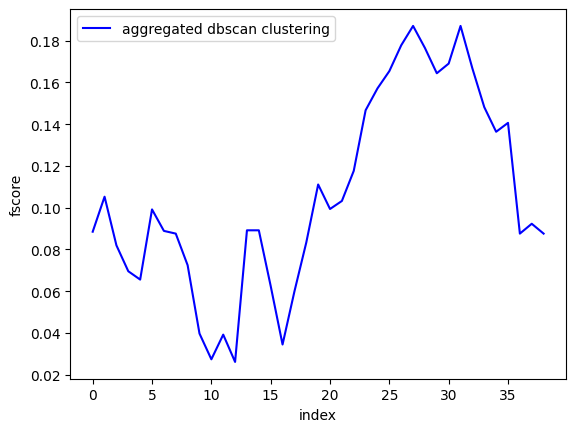

In [13]:
import matplotlib.pyplot as plt

plt.xlabel('index')  # Optional: Add X-axis label
metric = 'fscore'
plt.ylabel(metric)  # Optional: Add Y-axis label
colors = ['blue','orange','red']
plt.plot(df['index'].values, df[metric].values,color='blue',label='aggregated dbscan clustering')

plt.legend()

### Table for comparing averaged metrics over the dataset

In [14]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names =  ['Metric'] +  ['DBScan Aggregated Method 3']

metrics = ['recall','precision','fscore']
for i in range(3): 
        row = [metrics[i]]
        row.append(round(df[metrics[i]].mean(),3))
        table.add_row(row)

print(table)

+-----------+----------------------------+
|   Metric  | DBScan Aggregated Method 3 |
+-----------+----------------------------+
|   recall  |           0.078            |
| precision |           0.171            |
|   fscore  |           0.106            |
+-----------+----------------------------+
